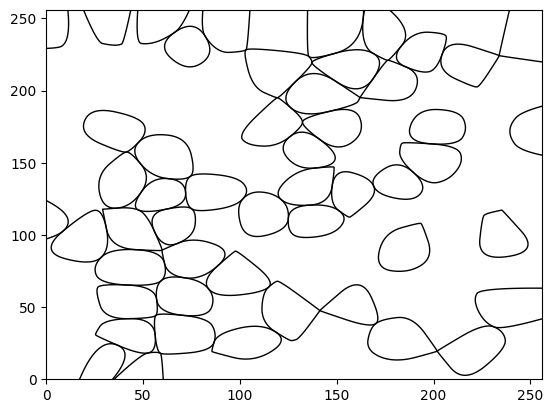

In [2]:
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, Polygon, Point, GeometryCollection
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from scipy.interpolate import splprep, splev
from shapelysmooth import chaikin_smooth


from typing import Optional, List

class Region:
    polygon: Polygon # Geometrical entity defining this area (boundaries)
    repr: Polygon # Representation of the object contained in this region. (e.g., cell or organelle)
    parent: 'Optional[Region]'
    children: 'List[Region]'
    boundary_size: int

    subdivision_points: List[List[tuple]]
    # Some other properties
    
    def __init__(self, polygon: Polygon, parent: 'Optional[Region]' = None) -> None:
        self.polygon = polygon 
        self.parent = parent
        self.depth = 0
        self.repr=None
        if parent is not None:
            self.parent.add_child(self)
            self.depth = self.parent.depth + 1
        self.children: List[Region] = []

    def __str__(self) -> str:
        return f"Region, Depth {self.depth}, Area {self.polygon.area} Verts: {len(self.polygon.exterior.xy[0])} XY: {self.polygon.exterior.xy} "

    def _poly_coords(self, as_numpy=False):
        """
            Coordinates of the boundaries of this region
        """
        coords = self.polygon.exterior.coords
        if as_numpy:
            return np.array(coords)
        return coords
    
    def _repr_coords(self, as_numpy=False):
        """
            Coordinates of the object inside this region
        """
        coords = self.repr.exterior.coords
        if as_numpy:
            return np.array(coords)
        return coords

    def subdivide_voronoi(self, n_points=8, min_distance=20, center_std=10, distance_from_border=10):
        """
            Generate children regions using voronoi
        """
        # TODO: Save params
        self.subdivision_points = self._sample_points(n_points=n_points, center_std=center_std, min_distance=min_distance, mid_distance_from_edges=distance_from_border)
        voronoi_geometries = voronoi_diagram(MultiPoint(self.subdivision_points), envelope=self.polygon) # FIXME: the envelope seems to be taken as the bounding box of polygon, not the polygon itself
        for poly in voronoi_geometries.geoms:
            Region(polygon=poly, parent=self)

    def represent_smooth(self, prob=1.0, recursive=True):
        """
            Adds a representation using smoothing
        """

        self.repr = chaikin_smooth(self.polygon, 10, False)
        
        if recursive:
            for ch in self.children:
                if np.random.uniform() <= prob:
                    ch.represent_smooth(recursive=True)

    def plot(self, ax=None, plot_repr=True, plot_poly=False):
        """
            Plots the tree of geometrical regions
        """

        
        if self.depth > 0:
            if plot_poly:
                mpl_polygon = MplPolygon(self._poly_coords(as_numpy=True), closed=True, edgecolor='black', facecolor="none")
                ax.add_patch(mpl_polygon)
            if plot_repr and self.repr is not None:
                mpl_polygon = MplPolygon(self._repr_coords(as_numpy=True), closed=True, edgecolor='black', facecolor="none")
                ax.add_patch(mpl_polygon)
            
            
        else:
            fig, ax = plt.subplots()

            # Set axis limits based on the polygon bounds of the root region
            minx, miny, maxx, maxy = self.polygon.bounds
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)

        for ch in self.children:
            ch.plot(ax, plot_repr=plot_repr, plot_poly=plot_poly)

    def add_child(self, other):
        """
        
        """
        self.children.append(other)
    
    def _get_random_point(self, existing_points, min_distance, boundary: Polygon):
        """
            Generates a random point that is ensured to lay whithin the provided boundary.
        """
        while True:
            # Generate random point inside the polygon's bounding box
            minx, miny, maxx, maxy = boundary.bounds
            x = np.random.uniform(minx, maxx)
            y = np.random.uniform(miny, maxy)
            new_point = Point(x, y)

            # Ensure point lies inside the inner polygon and respects the minimum distance
            if boundary.contains(new_point) and all(new_point.distance(p) >= min_distance for p in existing_points):
                return new_point

    def _sample_points(self, n_points, center_std, min_distance, mid_distance_from_edges):
        """
        Samples points inside the current polygon while ensuring that points maintain the specified minimum distance.
        
        Args:
            n_points: Number of points to sample.
            center_std: Standard deviation for jittering the central point.
            min_distance: Minimum distance between points
            mid_distance_from_edges: Minimum distance from the border of the polygon.
        
        Returns:
            List of sampled points.
        """
        # Create an inset polygon that ensures the distance from the border
        inner_polygon = self.polygon.buffer(-mid_distance_from_edges)

        if inner_polygon.is_empty:
            raise ValueError("The polygon is too small to maintain the specified distance from the border.")

        points = []

        # Sample the first point around the polygon's centroid with some jitter
        centroid = inner_polygon.centroid
        x_jittered = np.random.normal(centroid.x, center_std)
        y_jittered = np.random.normal(centroid.y, center_std)
        center_point = Point(x_jittered, y_jittered)

        if inner_polygon.contains(center_point):
            points.append(center_point)
        else:
            points.append(centroid)  # Fallback to centroid if jittered point is out of bounds

        # Sample remaining points
        for _ in range(n_points - 1):
            point = self._get_random_point(points, min_distance, boundary=self.polygon)
            points.append(point)

        return points
    

class CellSimulator:
    size: int  # Image size
    image_boundaries: Polygon

    def __init__(self, size=256) -> None:
        self.size = size
        

    def sample(self, cell_prob=1.0, n_points=8, min_distance=20, center_std=10, distance_from_border=10):
        self.image_boundaries = Polygon([(0, 0), (self.size, 0), (self.size, self.size), (0, self.size)])
        root_region = Region(self.image_boundaries, parent=None)
        root_region.subdivide_voronoi( n_points=n_points, min_distance=min_distance, center_std=center_std, distance_from_border=distance_from_border)
        root_region.represent_smooth(prob=cell_prob)
        return root_region


simulator = CellSimulator()
img = simulator.sample(n_points=100, cell_prob=.5)
img.plot()
plt.show()
